# Analysis of QHD_G75 Covalent on nCov 

The main task of this notebook is to extract and explain a number of features one can get from a Molecular Dynamics simulation. For each feature I include a brief explanation (with te respective references), the code and/or GROMACS command to extract it and a useful plot.
  
I extracted these features from these [molecular dynamics files](https://figshare.com/articles/Molecular_dynamics_simulations_of_coronavirus_2019-nCoV_protease_model_in_complex_with_G75_and_G82_ligands_covalently_bound_/11788794) of the nCov protease and the G75 ligand.

  
  
**Simulation info**:
* 500ps frame window
* 310K temperature

**Tools used**:
* [MDAnalysis](https://www.mdanalysis.org/), offering parsing and analysis MD trajectories
* [MDtraj](http://mdtraj.org/latest/index.html), complementary analysis methods of MDAnalysis
* [GROMACS](http://www.gromacs.org/), performing and analyzing MD simulations
* [VDM](https://www.ks.uiuc.edu/Research/vmd/), protein and trajectory visualization tool
* [Grace](http://plasma-gate.weizmann.ac.il/Grace/), used for the plotting of `.xvg` files

## Importing and reading the files

In [1]:
import MDAnalysis
import mdtraj as md_traj

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

In [2]:
# Create the universe of atoms
# I have used both MDAnalysis and MDtraj packages since they have complementary methods
u = MDAnalysis.Universe('../datasets/QHD_G75_covalent/QHD_G75_covalent.gro', # topology
                        '../datasets/QHD_G75_covalent/QHD_G75_covalent.xtc') # trajectory

# t = md_traj.load('../datasets/QHD_G75_covalent/QHD_G75_covalent.xtc', # trajectory
#             top='../datasets/QHD_G75_covalent/QHD_G75_covalent.gro')  # topology

print("MD Analysis check:")
print(u)

# print("MD Traj check:")
# print(t)

MD Analysis check:
<Universe with 4752 atoms>


## Extracting basic info

In [7]:
uni_atom_group = u.atoms

print(len(u.atoms))
print(len(u.residues))
print(f'{len(u.trajectory)}')
print(f'Coordinates shape: {uni_atom_group.positions.shape}')  # Coordinates of each atom on the starting position
print(f'Center of mass: {uni_atom_group.center_of_mass()}') # Center of mass on the 3 axes
print(f'Total mass: {uni_atom_group.total_mass()}') # Total mass of atoms

4752
307
50004
Coordinates shape: (4752, 3)
Center of mass: [78.4322688  75.00627472 36.69610656]
Total mass: 34300.277


## Progression of the basic info

Having only the starting position does not help us make any useful conclusions. Now we will extract info from observing the progression of the above attributes through the trajectory frames.

**DISCLAIMER: This is a showcase of how to extract each feature without taking into account water molecules, lack of alignment etc. These must be carefully considered. It should also be noted that GROMACS in most cases performs the alignment without asking** 

A list of **covered features**:
* Radius of Gyration
* Solvent-Accesible Surface Area (SASA)
* Root Mean Square Fluctuations (RMSF)
* Principal Component Analysis (PCA)

### Radius of Gyration

Radius of gyration is an indicator of protein structure compactness. It is concerned with how regular secondary structures are compactly packed into 3D structure of protein. α proteins have the highest radius of gyration throughout the protein size range considered, suggesting a less tight packing as compared with β-and (α + β)-proteins. The lowest radius of gyration and, accordingly, the tightest packing are a characteristic of α/β-proteins [(ref)](https://www.researchgate.net/publication/226987521_Radius_of_gyration_as_an_indicator_of_protein_structure_compactness).
If a protein is stably folded, it will likely maintain a relatively steady value of Rg. If a protein unfolds, its Rg will change over time [(ref)](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0112456&type=printable).

\begin{equation*}
Rg^2 = \sum_{i=1}^N m_i\left( r_i - R_c \right)^2 
\end{equation*}

$R_c$ the center of mass (excluding hydrogens)  
$r_i$ the coordinates of the i_th atom  
$m_i$ the mass of the ith atom.

**GROMACS command**: `gmx gyrate -s topology.tpr -f trajectory.xtc -o outputfile.xvg`

**Python tool used:**: MDAnalysis

**Calculation time**" < 1 minute


        
 

Total frames: 50004


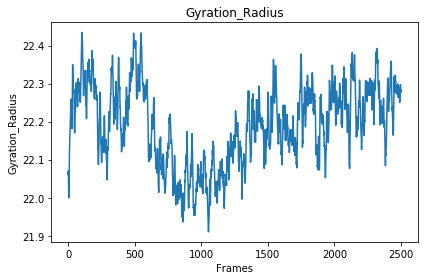

In [5]:
print(f'Total frames: {len(u.trajectory)}')

frame_indexes = np.arange(len(u.trajectory[::20]))

basic_info_dict = {
    "Gyration_Radius":[],
}

for ts in u.trajectory[::20]:
    basic_info_dict["Gyration_Radius"].append(u.atoms.radius_of_gyration())



for which_key, count in zip(basic_info_dict.keys(), range(len(basic_info_dict))):
    plt.subplot(1, 1, count + 1)
    plt.plot(frame_indexes, basic_info_dict[which_key], label=which_key)
    plt.xlabel("Frames")
    plt.ylabel(which_key)
    plt.title(which_key)

plt.tight_layout()
plt.show()

### Solvent-Accesible Surface Area (SASA)

The accessible surface area (ASA) or solvent-accessible surface area (SASA) is the surface area of a biomolecule that is accessible to a solvent [(ref)](http://compbio.biosci.uq.edu.au/mediawiki/upload/d/d5/Lee1971_JMolBiol55-379.pdf). Measurement of ASA is usually described in units of square Ångstroms (a standard unit of measurement in molecular biology). ASA is typically calculated using the 'rolling ball' algorithm developed by Shrake & Rupley in 1973. This algorithm uses a sphere (of solvent) of a particular radius to 'probe' the surface of the molecule [(ref)](https://www.sciencedirect.com/science/article/abs/pii/0022283673900119?via%3Dihub).


Changes of the SASA indicate a change in the conformation of the protein and unfolding.

**GROMACS command**: `gmx sasa -f trajectory.xtc -s topology.tpr -o sasa.xvg`

**Python tool used**: None

**Calculation time**: ~= 30 minutes

<img src="https://drive.google.com/uc?export=view&id=17CHp_-xbBPDuRM13SmvmCMpc4Y1i2jwS" alt="drawing" width="200"/>

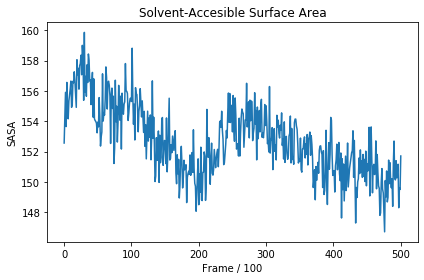

In [51]:
# Read the SASA file and plot it over the frames
# The SASA file must be created with the GROMACS command: gmx sasa -f trajectory.xtc -s topology.tpr -o sasa.xvg

sasa_list = []
p = re.compile('\s+([0-9\.]*)\s+([0-9\.]*)\\n')    # RegEx to extract the frame, SASA pair of each frame
                                                
with open("../datasets/QHD_G75_covalent/sasa.xvg") as fp:
    Lines = fp.readlines() 
    for line in Lines:
        if(line[0] != '#' and line[0] != '@'):    #Ignore the GROMACS comment lines
            m = p.match(line)
            sasa_list.append([m.group(1), m.group(2)]) # Group1: Frame, Group2: SASA

sasa_list_arr = np.array(sasa_list).T.astype('float64') # Cast to numpy array and transpose to have x, y axis values

plt.plot()
plt.title("Solvent-Accesible Surface Area")    
plt.xlabel('Frame / 100')
plt.ylabel('SASA')
plt.plot(sasa_list_arr[0][::100],sasa_list_arr[1][::100], label='SASA')
plt.tight_layout()

plt.show() 


### Root Mean Square Flactuation (RMSF)

RMSF is a measure of the deviation of the position of a particle i with respect to a reference position **over time**.

**Difference between RMSD and RMSF**: The latter is averaged over time, giving a value for each particle i. For the RMSD the average is taken over the particles, giving time specific values. So **RMSD is time specific** and **RMSF is atom specific** [(ref)](http://www.drugdesign.gr/uploads/7/6/0/2/7602318/lecture_mdanalysis.pdf).

\begin{equation*}
RMSF_i = \left[ \frac{1}{T} \sum_{t_j=1}^T \mid r_i(t_j) - r_i^\text{ref} \mid ^ 2 \right] ^ \frac{1}{2}
\end{equation*}

$T$ is the total simulation time  
$r_i^\text{ref}$ is the reference position of particle $i$, like the **time-averaged** position of the same particle $i$  

**GROMACS command**: `gmx rmsf -f trajectory.xtc -s topology.gro -o rmsf.xvg` 
  
**Python tool**: MDAnalysis [(ref)](https://www.mdanalysis.org/mdanalysis/documentation_pages/analysis/rms.html#)  
  
**Calculation time**: < 1 minute  
  

Step 50004/50004 [100.0%]


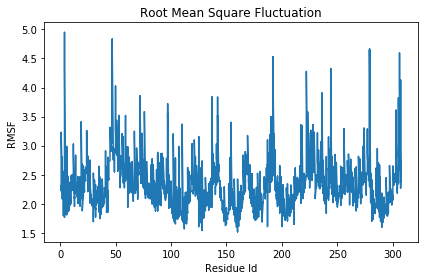

In [12]:
from MDAnalysis.analysis.rms import RMSF
from MDAnalysis.analysis import align

# In this case the alignment step (which is ommited) is important
rmsfer = RMSF(u.atoms, verbose=True).run()

plt.plot()
plt.title("Root Mean Square Fluctuation")    
plt.xlabel('Residue Id')
plt.ylabel('RMSF')
plt.plot(u.atoms.resnums, rmsfer.rmsf)
plt.tight_layout()
plt.show()


In [93]:
# Top 10 RMSF residues
ind = np.argpartition(rmsfer.rmsf, -10)[-10:]
ind = ind[np.argsort(rmsfer.rmsf[ind])]

arr = np.flip(ind)    # Flip the top10 indexes since we want descending order
arr = np.stack((arr, np.array(u.atoms.resnums[arr])))    # Stack the Residue Ids
arr = np.vstack((arr, np.array(rmsfer.rmsf[arr[0]])))    # Stack the RMSFs

df = pd.DataFrame(arr.T, columns=['Atom Id', 'Residue Id', 'RMSF'])    # Convert to dataframe for prettier print
print(df)


   Atom Id  Residue Id      RMSF
0     60.0         4.0  4.948613
1    702.0        47.0  4.834833
2    705.0        47.0  4.821866
3     59.0         4.0  4.796542
4   4267.0       279.0  4.664557
5    706.0        47.0  4.717558
6   4270.0       279.0  4.645208
7   4679.0       306.0  4.591486
8    703.0        47.0  4.540010
9   2930.0       192.0  4.531647


### Principal Component Analysis (PCA)

PCA is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly **uncorrelated variables** called principal components.  
PCA is employed on MD analysis to reveal **the most important motions in proteins**. PCA is a linear transformation that extracts the most important elements in the data using a covariance matrix or a correlation matrix (normalized PCA) constructed from atomic coordinates that describe the accessible Degrees Of Freedom of the protein, such as the Cartesian coordinates that define atomic displacements in each conformation (frame) comprising a trajectory.

**Cartesian Coordinate Based PCA** [(ref including analysis of PCA results)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4676806/pdf/nihms739932.pdf):  
1. Remove overall translations and rotation by aligning each frame to a reference structure
2. Choose a set of atoms for the analysis (eg alpha carbons)
3. Center the variables (row centering). Currently we have a $3m x n$ matrix ($m$ selected atoms, $n$ frames)
4. Construct the covariance matrix $3mx3m$
5. Diagonalize the covariance matrix
6. Examine the scree plot to determine  the number of eigenvectors to include in the reduced vector space that describes the most relevant features
7. Examine component loadings which give us the percent of variance by the PCs

  
**GROMACS commands**: 
 1. `gmx covar -f trajecory.xtc -s topology.gro -v eigvec.trr -o eigval.xvg`, [build and diagonalize cov matrix](http://manual.gromacs.org/documentation/2018/onlinehelp/gmx-covar.html)          
 2. `gmx anaeig -v eigvec.trr -eig eigval.xvg -f trajecory.xtc -s topology.gro  -ANALYZE_OPTION`, [analyze eigenvectors](http://manual.gromacs.org/documentation/2018/onlinehelp/gmx-anaeig.html)
  
**Python tool**: MDAnalysis, [(ref)](https://www.mdanalysis.org/docs/documentation_pages/analysis/pca.html#module-MDAnalysis.analysis.pca)

**Calculation time**: ~= 5 minutes
  




In [3]:
import MDAnalysis.analysis.pca as pca
#TODO: Check if the frames are aligned

# I will apply PCA only on the alpha carbons like the paper I linked above does
ca_pca = pca.PCA(u, select='name CA')
ca_pca.run()

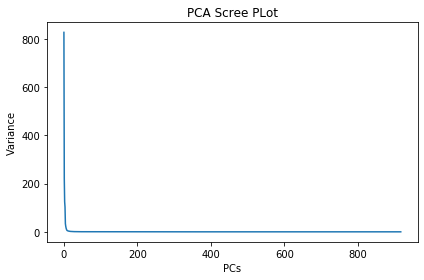

(918,)
386.3251948858101


In [63]:
# Scree Plot
plt.plot()
plt.title('PCA Scree PLot')    
plt.xlabel('PCs')
plt.ylabel('Variance')
plt.plot(np.arange(len(ca_pca.cumulated_variance)), ca_pca.variance)
plt.tight_layout()
plt.show()

# Calculate component loadings
loads = ca_pca.p_components @ np.sqrt(ca_pca.variance)
print(loads.shape)
print(np.sum(loads))
# Get the PCs that give us 95% variance
n_pcs = np.where(ca_pca.cumulated_variance > 0.95)[0][0]
atomgroup = u.select_atoms('name CA')

# Transform our alpha carbon atoms to the first k PCs, resulted shape: #frames, k
# pca_space = ca_pca.transform(atomgroup, n_components=n_pcs)
# print(pca_space.shape)

In our example we projected from 50.004x306 (50.004 frames, 306 alpha carbon atoms) to 50.004x11 where 11 is the number of principal components that give us a variance > 0.95. On this lower dimension representation is more easy to extract and observe **large scale motions** of our simulation which are often the most biologically relevant[(ref)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4676806/pdf/nihms739932.pdf). These motions can be observed by applying the usual techniques (RMSF, Rg, SASA etc.).

#### 2D Projection
In order to be able to plot the structural motion we **can project our data on the first 2 PCs** [(ref)](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0112456&type=printable).

In [5]:
pca_space_2D = ca_pca.transform(atomgroup, 2)

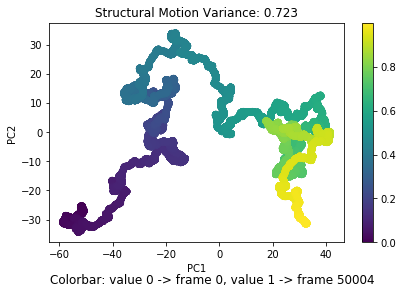

In [57]:
# Scatter plot on PC1, PC2
# As color goes from 0 to 1, frames go from 0 to 50004

step = 1    # Frames we are skipping for computational reasons
plt.scatter(pca_space_2D[::step, 0], pca_space_2D[::step, 1], c=np.arange(len(pca_space_2D) / step) / (len(pca_space_2D) / step), marker='o')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Structural Motion Variance: {np.around(ca_pca.cumulated_variance[1], decimals=3)}')
caption = f'Colorbar: value 0 -> frame 0, value 1 -> frame {len(pca_space_2D)}'
plt.figtext(0.5, 0.001, caption, wrap=True, horizontalalignment='center', fontsize=12)
plt.tight_layout()
plt.colorbar()
plt.show()

### Hydrogen Bonds

Hydrogen bond is formed when an electronegative atom (H-bond acceptor, A) approaches a hydrogen atom bonded to another electronegative atom (H-bond donor, D).   
During folding process, the unfolded structure collapses first to minimize the area of hydrophobic surface that is exposed to the solvent and hydrogen bonds begin to form. Hydrogen bonds, providing most of the directional interactions, are the dominant feature in the formation of protein secondary or tertiary structures. They play an indispensable role in the stabilization of the native structure of a protein [(ref)](https://www.intechopen.com/books/advanced-materials-for-renewable-hydrogen-production-storage-and-utilization/treatment-of-hydrogen-bonds-in-protein-simulations).

Hydrogen bonds are recorded based on a geometric criterion:

1. The **distance** between acceptor and hydrogen is less than or equal to $Dist_\text{cutoff}$.
2. The **angle** between donor-hydrogen-acceptor is greater than or equal to $Angle_\text{cutoff}$.
  
**GROMACS command**: The command is `gmx hbond` but I have not managed to run it on my example
  
**Python tool**: MDAnalysis
  
**Calculation Time**: NaN

In [71]:
import MDAnalysis.analysis.hbonds

h_bonds = MDAnalysis.analysis.hbonds.HydrogenBondAnalysis(u, distance=3.0, angle=120.0)
h_bonds.run()

KeyboardInterrupt: 

In [ ]:
print(h_bonds.count_by_time())

### Salt Bridge

In chemistry, a salt bridge is a combination of two non-covalent interactions: hydrogen bonding and ionic bonding.

I was not able to find any Python tool able to extract salt bridges and also I was not able to udnerstand how to extract them from distances and angles.
I ended up following this anwser of [using VDM to extract salt bridges](https://www.researchgate.net/post/Can_anyone_help_with_salt_bridges_with_gromacs).

**Open VDM -> load topology and trajectory -> Extensions -> Analysis -> Salt Bridges**

The result is a file containing the name of the residues forming a salt bridge.
e.g. ASP197-ARG131, GLU288-LYS5 etc.
Also for every salt bridge there is a file with distances over all frames for each salt bridge.